# **Decision tree implementation from scratch**

**NOTE**: I have only used sklearn for model evaluation not in algorithms and also the diseases dataset provided was scattered so I used the csv file where all the features were in one place as I did not know how to process .data files I have attached the dataset along for any further inspection.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('iris.csv')
X = df.drop('species', axis=1).values
y = df['species'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def entropy(y):
    counter = Counter(y)
    total = len(y)
    ent = -sum((count / total) * math.log2(count / total) for count in counter.values())
    return ent

def gini_impurity(y):
    counter = Counter(y)
    total = len(y)
    gini = 1 - sum((count / total) ** 2 for count in counter.values())
    return gini

def information_gain(y, y_left, y_right, criterion='entropy'):
    if criterion == 'entropy':
        parent_entropy = entropy(y)
        left_entropy = entropy(y_left)
        right_entropy = entropy(y_right)
    elif criterion == 'gini':
        parent_entropy = gini_impurity(y)
        left_entropy = gini_impurity(y_left)
        right_entropy = gini_impurity(y_right)

    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)

    gain = parent_entropy - (weight_left * left_entropy + weight_right * right_entropy)
    return gain

def split_data(X, y, feature_index, threshold):
    left_indices = np.where(X[:, feature_index] <= threshold)[0]
    right_indices = np.where(X[:, feature_index] > threshold)[0]
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

class DecisionTree:
    def __init__(self, criterion='entropy', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _best_split(self, X, y):
        best_gain = -1
        best_split = None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right, criterion=self.criterion)

                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': (X_left, y_left),
                        'right': (X_right, y_right)
                    }

        return best_split

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        best_split = self._best_split(X, y)
        if not best_split:
            return Counter(y).most_common(1)[0][0]

        left_subtree = self._build_tree(*best_split['left'], depth + 1)
        right_subtree = self._build_tree(*best_split['right'], depth + 1)

        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict(self, inputs, node):
        if not isinstance(node, dict):
            return node

        feature_index = node['feature_index']
        threshold = node['threshold']

        if inputs[feature_index] <= threshold:
            return self._predict(inputs, node['left'])
        else:
            return self._predict(inputs, node['right'])

    def predict(self, X):
        return [self._predict(inputs, self.tree) for inputs in X]

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

tree = DecisionTree(criterion='gini', max_depth=3)
tree.fit(X_train, y_train)
evaluate_model(tree, X_test, y_test)


Accuracy: 0.9333333333333333
Precision: 0.9458333333333333
Recall: 0.9333333333333333
F1-Score: 0.9324337831084458


# **Random forest implementation from scratch**

Accuracy: 0.7802197802197802
Precision: 0.7884615384615384
Recall: 0.82
F1-Score: 0.803921568627451
AUC: 0.7758536585365853


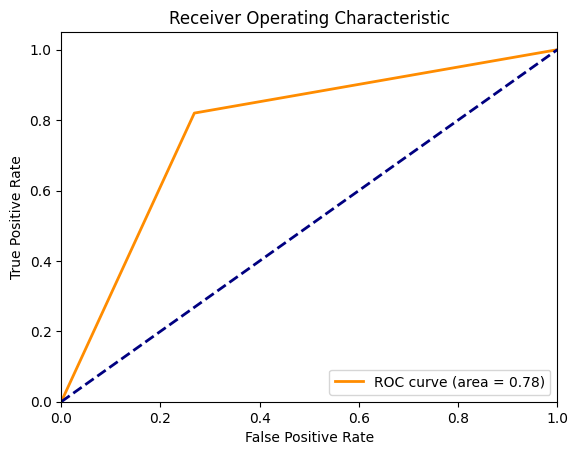

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

df = pd.read_csv('heart_disease.csv')
X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def entropy(y):
    counter = Counter(y)
    total = len(y)
    ent = -sum((count / total) * np.log2(count / total) for count in counter.values())
    return ent

def information_gain(y, y_left, y_right):
    parent_entropy = entropy(y)
    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)
    gain = parent_entropy - (weight_left * entropy(y_left) + weight_right * entropy(y_right))
    return gain

def split_data(X, y, feature_index, threshold):
    left_indices = np.where(X[:, feature_index] <= threshold)[0]
    right_indices = np.where(X[:, feature_index] > threshold)[0]
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _best_split(self, X, y, features):
        best_gain = -1
        best_split = None
        for feature_index in features:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gain = information_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': (X_left, y_left),
                        'right': (X_right, y_right)
                    }
        return best_split

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]
        features = np.random.choice(X.shape[1], size=int(np.sqrt(X.shape[1])), replace=False)
        best_split = self._best_split(X, y, features)
        if not best_split:
            return Counter(y).most_common(1)[0][0]
        left_subtree = self._build_tree(*best_split['left'], depth + 1)
        right_subtree = self._build_tree(*best_split['right'], depth + 1)
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict(self, inputs, node):
        if not isinstance(node, dict):
            return node
        feature_index = node['feature_index']
        threshold = node['threshold']
        if inputs[feature_index] <= threshold:
            return self._predict(inputs, node['left'])
        else:
            return self._predict(inputs, node['right'])

    def predict(self, X):
        return [self._predict(inputs, self.tree) for inputs in X]

class RandomForest:
    def __init__(self, n_trees=10, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        final_predictions = [Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return final_predictions

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')
    print(f'AUC: {roc_auc}')

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

rf = RandomForest(n_trees=10, max_depth=5)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)
